In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, make_scorer, brier_score_loss
from sklearn.calibration import calibration_curve
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
# from numpy.ma import MaskedArray
# from numpy import mean
# from numpy import std
# from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.metrics import average_precision_score
# # from sklearn.metrics import accuracy_score
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.inspection import permutation_importance
# import sklearn.utils.fixes
# sklearn.utils.fixes.MaskedArray = MaskedArray
# from lightgbm import LGBMClassifier
# from scipy.stats import spearmanr
# from scipy.cluster import hierarchy
# from scipy.spatial import distance
# monkey patch for bayesseachcv (https://github.com/scikit-optimize/scikit-optimize/issues/902)
# from skopt import BayesSearchCV
# from skopt.space import Real, Integer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Random state
seed = 42

In [3]:
# Setup metrics (see: http://business-analytic.co.uk/blog/evaluating-expected-goals-models/)
# define Mcfadden's pseduo r-squared
def mcfadden_r2(y, y_pred):
    ll = log_loss(y, y_pred)
    ll_null = log_loss(y, np.full(len(y), y.mean()))
    return 1 - (ll/ll_null)
pseudo_r2_scorer = make_scorer(mcfadden_r2, needs_proba=True, greater_is_better=True)

In [4]:
scoring = {'roc_aug': 'roc_auc', 'mcfaddens_r2': pseudo_r2_scorer}

In [5]:
# Load the data
cwd = os.getcwd()
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df.drop(['match_id', 'statsbomb_id','period', 'statsbomb_team_id', 'player_id_statsbomb', 'competition_gender', 'team_name',
         'player_id', 'firstName', 'middleName', 'lastName', 'Name', 'dataset', 'wyscout_id', 'wyscout_team_id', 'team_id',
         'player_id_wyscout','competition_name','minute','shot_zone'], axis=1, inplace=True)
mask_penalty = (df.shot_type_name=='penalty')
df_penalty = df[mask_penalty].copy()
df_penalty.drop(['assist_type', 'pass_end_y', 'pass_end_x', 'pass_switch', 'pass_cross', 'pass_cut_back',
         'pass_height_name', 'pass_technique_name', 'carry_length', 'shot_open_goal', 'shot_one_on_one', 'under_pressure',
         'area_shot', 'area_goal', 'n_angle', 'goalkeeper_x','goalkeeper_y','smart_pass',
         'shot_zone_number','shot_zone_player_number'], axis=1, inplace=True)
df_non_penalty = df[~mask_penalty].copy()
df_non_penalty.drop(['penalty_number'], axis=1, inplace=True)
X_penalty = df_penalty.drop('goal', axis=1)
y_penalty = df_penalty.goal
X = df_non_penalty.drop('goal', axis=1)
y = df_non_penalty.goal

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64663 entries, 5 to 65787
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   eventSec                 64663 non-null  float64
 1   shot_type_name           64663 non-null  object 
 2   x                        64663 non-null  float64
 3   y                        64663 non-null  float64
 4   counter_attack           64663 non-null  bool   
 5   fast_break               64663 non-null  bool   
 6   strong_foot              64663 non-null  bool   
 7   body_part_name           64663 non-null  object 
 8   assist_type              64663 non-null  object 
 9   pass_end_y               15635 non-null  float64
 10  pass_end_x               15635 non-null  float64
 11  pass_switch              44116 non-null  object 
 12  pass_cross               44116 non-null  object 
 13  pass_cut_back            44116 non-null  object 
 14  pass_height_name      

In [7]:
# Split into train, calibration and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=seed, stratify=y)
X_penalty_train, X_penalty_test, y_penalty_train, y_penalty_test = train_test_split(X_penalty, y_penalty,
                                                                        train_size=0.8, random_state=seed, stratify=y_penalty)

In [8]:
print('Shots train', len(y_train), ';Number goals', y_train.sum(),
      ';Goals %: ', round(y_train.mean()*100, 1))
print('Shots test', len(y_test), ';Number goals', y_test.sum(),
      ';Goals %: ', round(y_test.mean()*100, 1))

Shots train 51730 ;Number goals 5485 ;Goals %:  10.6
Shots test 12933 ;Number goals 1371 ;Goals %:  10.6


In [9]:
print('Penalty Shots train', len(y_penalty_train), ';Penalty Number goals', y_penalty_train.sum(),
      ';Penalty Goals %: ', round(y_penalty_train.mean()*100, 1))
print('Penalty Shots test', len(y_penalty_test), ';Penalty Number goals', y_penalty_test.sum(),
      ';Penalty Goals %: ', round(y_penalty_test.mean()*100, 1))

Penalty Shots train 717 ;Penalty Number goals 528 ;Penalty Goals %:  73.6
Penalty Shots test 180 ;Penalty Number goals 132 ;Penalty Goals %:  73.3


In [10]:
# Load and split fake data
df_fake = pd.read_parquet(os.path.join(cwd, 'data', 'fake_shots.parquet'))
df_fake.index = ['a'+str(idx) for idx in df_fake.index]
y_fake = df_fake.goal
X_fake = df_fake.drop('goal', axis=1)

In [11]:
print('Shots fake', len(y_fake), ';Goals %: ', round(y_fake.mean()*100, 1))

Shots fake 1000 ;Goals %:  3.4


# Logistic regression

In [12]:
# Subset dataset for logistic regression
# logistic regression does not deal well with dependent features
# The model will use the distance/ angle features capture these location features instead
# lots of missings for the below features as they come from StatsBomb data only.
# while logistic regression does not allow missings so I removed them
# drop colum
logistic_drop_cols = ['x', 'y',  
                      'pass_end_y', 'pass_end_x',  # <- note these were in Wyscout, but often were just the shot location
                      'eventSec', 'player_id_goalkeeper', 'goalkeeper_x', 'goalkeeper_y', 'carry_length', 
                      'shot_one_on_one', 'shot_open_goal','under_pressure', 'area_shot', 'area_goal', 'n_angle', 'smart_pass']
X_train_logistic = X_train.drop(logistic_drop_cols, axis=1).copy()
X_test_logistic = X_test.drop(logistic_drop_cols, axis=1).copy()

In [13]:
# Split dataset for logistic regession into passes / other assists
def split(X, y):
    mask = X.assist_type == 'pass'
    X_pass = X[mask].drop('assist_type', axis=1).copy()
    y_pass = y[mask]
    X_other = X[~mask].dropna(axis=1, how='all').copy()
    y_other = y[~mask]
    return X_pass, y_pass, X_other, y_other

In [14]:
X_train_pass, y_train_pass, X_train_other, y_train_other = split(X_train_logistic, y_train)
X_test_pass, y_test_pass, X_test_other, y_test_other = split(X_test_logistic, y_test)

In [15]:
# Pipeline for cleaning pass assists
cols = ['shot_type_name', 'body_part_name', 'pass_technique_name', 'pass_height_name','H_A_column','match_moment']
cats = [['open_play', 'free_kick', 'corner', 'throw_in'],
        ['Right Foot', 'Left Foot', 'Other'],
        ['other', 'Through Ball', 'Straight', 'Inswinging', 'Outswinging'],
        ['Ground/ Low Pass', 'High Pass'],
        ['Home Team', 'Away Team'],
        ['0-15','15-30','30-45','45-60','60-75','75-90']]
pass_one_hot = ColumnTransformer([('encoder', OneHotEncoder(drop='first', categories=cats), cols)], remainder='passthrough')
pipe_pass = Pipeline([('one_hot', pass_one_hot),
                      ('impute', SimpleImputer()),
                      ('scale', StandardScaler()),
                      ('lr', LogisticRegression(random_state=seed))])

In [16]:
# Column names of transformed pass data
original_cols_remain = [col for col in X_train_pass.columns if col not in cols]
new_cols_pass = [item for sublist in cats for i, item in enumerate(sublist) if (i>0)]
new_cols_pass.extend(original_cols_remain)

In [17]:
new_cols_pass

['free_kick',
 'corner',
 'throw_in',
 'Left Foot',
 'Other',
 'Through Ball',
 'Straight',
 'Inswinging',
 'Outswinging',
 'High Pass',
 'Away Team',
 '15-30',
 '30-45',
 '45-60',
 '60-75',
 '75-90',
 'counter_attack',
 'fast_break',
 'strong_foot',
 'pass_switch',
 'pass_cross',
 'pass_cut_back',
 'visible_angle',
 'middle_angle',
 'distance_to_goal',
 'distance_visible_angle',
 'log_distance_to_goal',
 'match_week',
 'players',
 'players_rival',
 'shot_number',
 'shot_zone_number',
 'shot_player_number',
 'shot_zone_player_number']

In [18]:
print(new_cols_pass)

['free_kick', 'corner', 'throw_in', 'Left Foot', 'Other', 'Through Ball', 'Straight', 'Inswinging', 'Outswinging', 'High Pass', 'Away Team', '15-30', '30-45', '45-60', '60-75', '75-90', 'counter_attack', 'fast_break', 'strong_foot', 'pass_switch', 'pass_cross', 'pass_cut_back', 'visible_angle', 'middle_angle', 'distance_to_goal', 'distance_visible_angle', 'log_distance_to_goal', 'match_week', 'players', 'players_rival', 'shot_number', 'shot_zone_number', 'shot_player_number', 'shot_zone_player_number']


In [19]:
# Pipeline for cleaning other assists
# setting direct to recovery so does not not encoded twice ( also covered by shot_type_name == 'direct_set_piece')
X_train_other.loc[X_train_other.assist_type == 'direct', 'assist_type'] = 'recovery'
X_test_other.loc[X_test_other.assist_type == 'direct', 'assist_type'] = 'recovery'

cols = ['shot_type_name', 'body_part_name', 'assist_type','H_A_column','match_moment']
cats = [['open_play', 'free_kick', 'corner', 'throw_in', 'direct_set_piece'],
        ['Right Foot', 'Left Foot', 'Other'],
        ['recovery', 'clearance', 'rebound'],
        ['Home Team', 'Away Team'],
        ['0-15','15-30','30-45','45-60','60-75','75-90']]
other_one_hot = ColumnTransformer([('encoder', OneHotEncoder(drop='first', categories=cats), cols)], remainder='passthrough')
pipe_other = Pipeline([('one_hot', other_one_hot),
                       ('impute', SimpleImputer()),
                       ('scale', StandardScaler()),
                       ('lr', LogisticRegression(random_state=seed))])

In [20]:
# Column names of transformed passes
original_cols_remain = [col for col in X_train_other.columns if col not in cols]
new_cols_other = [item for sublist in cats for i, item in enumerate(sublist) if (i>0)]
new_cols_other.extend(original_cols_remain)

In [21]:
original_cols_remain

['counter_attack',
 'fast_break',
 'strong_foot',
 'visible_angle',
 'middle_angle',
 'distance_to_goal',
 'distance_visible_angle',
 'log_distance_to_goal',
 'match_week',
 'players',
 'players_rival',
 'shot_number',
 'shot_zone_number',
 'shot_player_number',
 'shot_zone_player_number']

In [22]:
print(new_cols_other)

['free_kick', 'corner', 'throw_in', 'direct_set_piece', 'Left Foot', 'Other', 'clearance', 'rebound', 'Away Team', '15-30', '30-45', '45-60', '60-75', '75-90', 'counter_attack', 'fast_break', 'strong_foot', 'visible_angle', 'middle_angle', 'distance_to_goal', 'distance_visible_angle', 'log_distance_to_goal', 'match_week', 'players', 'players_rival', 'shot_number', 'shot_zone_number', 'shot_player_number', 'shot_zone_player_number']


In [23]:
# Search parameters for gridsearchcv
param_grid = {'lr__C': np.logspace(-3, 0.1, 100)}

In [24]:
# Fit the inner grid search for shots assisted by passes
clf_pass = GridSearchCV(estimator=pipe_pass, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1)
clf_pass.fit(X_train_pass, y_train_pass)
print('C:', clf_pass.best_estimator_.named_steps.lr.C)

C: 0.03953390342037077


In [25]:
clf_pass

GridSearchCV(estimator=Pipeline(steps=[('one_hot',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('encoder',
                                                                         OneHotEncoder(categories=[['open_play',
                                                                                                    'free_kick',
                                                                                                    'corner',
                                                                                                    'throw_in'],
                                                                                                   ['Right '
                                                                                                    'Foot',
                                                                                                    'Left '
        

In [26]:
# Fit the inner grid search for shots assisted other than passes
clf_other = GridSearchCV(estimator=pipe_other, param_grid=param_grid, scoring='neg_log_loss', n_jobs=-1)
clf_other.fit(X_train_other, y_train_other)
print('C:', clf_other.best_estimator_.named_steps.lr.C)

C: 0.11659144011798322


In [27]:
# Outer loops for unbiased estimates of the model accuracy
nested_score_pass = cross_validate(clf_pass, X=X_train_pass, y=y_train_pass, scoring=scoring, n_jobs=-1)
print('ROC AUC for shots assisted by passes:', nested_score_pass['test_roc_aug'].mean())
print("McFadden's Pseudo R-squared shots assisted by passes:", nested_score_pass['test_mcfaddens_r2'].mean())

Exception in thread Thread-6:
Traceback (most recent call last):
  File "C:\Users\sergi77\anaconda3\envs\xGenv\lib\site-packages\psutil\_pswindows.py", line 679, in wrapper
    return fun(self, *args, **kwargs)
  File "C:\Users\sergi77\anaconda3\envs\xGenv\lib\site-packages\psutil\_pswindows.py", line 863, in kill
    return cext.proc_kill(self.pid)
PermissionError: [WinError 5] Acceso denegado: '(originated from OpenProcess)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\sergi77\anaconda3\envs\xGenv\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\sergi77\anaconda3\envs\xGenv\lib\site-packages\joblib\externals\loky\process_executor.py", line 558, in run
    self.terminate_broken(bpe)
  File "C:\Users\sergi77\anaconda3\envs\xGenv\lib\site-packages\joblib\externals\loky\process_executor.py", line 736, in terminate_broken
    self.kill_workers()
  File "C:\Users\sergi77\anaconda3\e

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [28]:
nested_score_other = cross_validate(clf_other, X=X_train_other, y=y_train_other, scoring=scoring, n_jobs=-1)
print('ROC AUC for other model:', nested_score_other['test_roc_aug'].mean())
print("McFadden's Pseudo R-squared for other model:", nested_score_other['test_mcfaddens_r2'].mean())

ROC AUC for other model: 0.7971591662016942
McFadden's Pseudo R-squared for other model: 0.18062363914567625


# Test

In [29]:
# logistic regression
y_pred_lr_pass = clf_pass.predict_proba(X_test_pass)[:, 1]
y_pred_lr_other = clf_other.predict_proba(X_test_other)[:, 1]
y_pred_lr = np.concatenate([y_pred_lr_pass, y_pred_lr_other])
y_true_test = np.concatenate([y_test_pass, y_test_other])
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_true_test, y_pred_lr, n_bins=10)

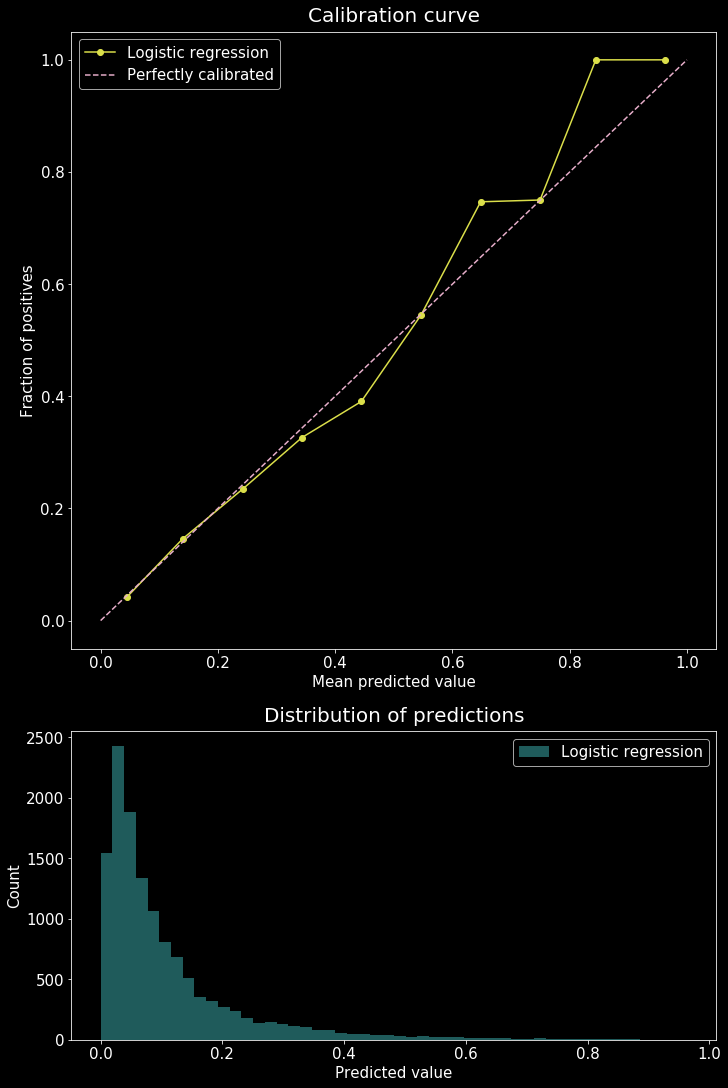

In [30]:
# Plot calibration curve on test data
plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(10, 15))
gs = fig.add_gridspec(ncols=1, nrows=2, height_ratios=(2/3, 1/3))
ax1 = fig.add_subplot(gs[0])
ax1.plot(mean_predicted_value_lr, fraction_of_positives_lr, "-o", color='#dbdf4a', label='Logistic regression')
ax1.plot([0, 1], [0, 1], "--", color='#e7aeca', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=15)
ax1.set_ylabel('Fraction of positives', fontsize=15)
ax1.set_title('Calibration curve', fontsize=20, pad=10)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)
ax2 = fig.add_subplot(gs[1])
sns.distplot(y_pred_lr, color='#4fe4e4', label='Logistic regression', kde=False, ax=ax2)
ax2.set_xlabel('Predicted value', fontsize=15)
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15)
ax2.set_title('Distribution of predictions', fontsize=20, pad=10);
fig.savefig(os.path.join(cwd, 'figures', '22_calibration_curve.png'), bbox_inches = 'tight', pad_inches = 0.2)

In [31]:
print('Brier score, logistic regression:',brier_score_loss(y_true_test, y_pred_lr, pos_label=y_true_test.max()))
print('ROC AUC, logistic regression:', roc_auc_score(y_true_test, y_pred_lr))
print('Pseudo R-squared, logistic regression:', mcfadden_r2(y_true_test, y_pred_lr))

Brier score, logistic regression: 0.08015005097609117
ROC AUC, logistic regression: 0.7947564842751179
Pseudo R-squared, logistic regression: 0.17845697959044315


# Save models

In [32]:
dump(clf_pass.best_estimator_, os.path.join(cwd, 'models', 'lr_pass.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_pass.joblib']

In [33]:
dump(clf_other.best_estimator_, os.path.join(cwd, 'models', 'lr_other.joblib'))

['C:\\Users\\sergi77\\Desktop\\UNIR\\TFM\\xG_Model_TFM\\models\\lr_other.joblib']

# Save data

In [34]:
# reload shot dataset for ids
df = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
df = df[['match_id', 'wyscout_id', 'statsbomb_id']].copy()

In [35]:
X_train_other['goal'] = y_train_other
X_train_other['split'] = 'train'
X_test_other['goal'] = y_test_other
X_test_other['split'] = 'test'
df_other = pd.concat([X_train_other, X_test_other])
df_other = df_other.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_other.reset_index(drop=True, inplace=True)
df_other.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_other.parquet'))

In [36]:
X_train_pass['goal'] = y_train_pass
X_train_pass['split'] = 'train'
X_test_pass['goal'] = y_test_pass
X_test_pass['split'] = 'test'
df_pass = pd.concat([X_train_pass, X_test_pass])
df_pass = df_pass.merge(df, left_index=True, right_index=True, validate='1:1', how='left')
df_pass.reset_index(drop=True, inplace=True)
df_pass.to_parquet(os.path.join(cwd, 'data', 'modelling', 'lr_pass.parquet'))